In [38]:
from pathlib import Path
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import matplotlib as mpl
from tqdm.auto import tqdm
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
import umap.umap_ as umap
from sklearn.cluster import KMeans
import utils
import sys
import os
from environment import CONTEXTS_LABELS

In [39]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Loading Data

In [40]:
save_path = Path("save")
save_path.exists()

True

In [41]:
data_dir = save_path / "first_successful_run"
data_dir.exists()

True

In [42]:
data_path = data_dir / "data.tar"
data_path.exists()

True

In [43]:
data_dict = torch.load(data_path, weights_only=False, map_location=DEVICE)
data_dict.keys()

dict_keys(['rewards', 'steps', 'episodes', 'all_states', 'all_actions', 'losses', 'p', 'epsilons', 'weights_val_stats', 'biases_val_stats', 'weights_grad_stats', 'biases_grad_stats', 'net', 'env', 'weights', 'biases'])

In [ ]:
weights = data_dict["weights"]["val"]
len(weights) # between each layer


[Parameter containing:
 tensor([[-0.1220, -0.0477,  0.0714,  ..., -0.2147,  0.0021, -0.1300],
         [-0.1028,  0.1012, -0.1454,  ..., -0.0249,  0.2302, -0.1967],
         [ 0.1295, -0.0296,  0.0843,  ...,  0.1531,  0.2175, -0.0201],
         ...,
         [-0.0072,  0.0136,  0.0793,  ...,  0.0291,  0.0155, -0.1577],
         [-0.0345, -0.1304,  0.1492,  ..., -0.0699, -0.0678,  0.0542],
         [ 0.1478,  0.0755, -0.1270,  ..., -0.0003, -0.1663,  0.2247]],
        requires_grad=True),
 Parameter containing:
 tensor([[-3.1906e-02, -2.8767e-02, -3.0281e-02,  ..., -2.1350e-02,
           1.5068e-02, -4.3601e-02],
         [-3.1837e-02, -1.4346e-02, -2.4468e-02,  ..., -2.2355e-02,
           3.2835e-03,  2.1970e-02],
         [ 2.8376e-02, -3.4127e-02,  2.4270e-06,  ..., -2.2681e-02,
          -1.8196e-02, -4.4218e-02],
         ...,
         [-1.2550e-02,  2.1395e-02,  2.6282e-02,  ..., -1.0023e-03,
          -4.3867e-02,  6.3410e-03],
         [ 1.0887e-02, -2.9105e-02,  3.9696e-04,  

In [45]:
print(weights[0].shape) # there are 512 neurons, each connected to 19 inputs
print(weights[1].shape) # the hidden layers are 512x512
print(weights[4].shape) # the final layer has 3 neurons

torch.Size([512, 19])
torch.Size([512, 512])
torch.Size([3, 512])


In [46]:
weights[0][0] # each row is a neuron's weight vector

tensor([-0.1220, -0.0477,  0.0714, -0.1812, -0.0953,  0.0697,  0.0923, -0.2075,
        -0.1775, -0.0291, -0.2199,  0.1595, -0.1207, -0.2306, -0.2014, -0.1377,
        -0.2147,  0.0021, -0.1300], grad_fn=<SelectBackward0>)

## Model Architecture

In [47]:
'''
DQN(
      (mlp): Sequential(
        (Layer 0): Linear(in_features=19, out_features=512, bias=True)
        (Layer 1): Linear(in_features=512, out_features=512, bias=True)
        (): ReLU()
        (Layer 2): Linear(in_features=512, out_features=512, bias=True)
        (): ReLU()
        (Layer 3): Linear(in_features=512, out_features=512, bias=True)
        (): ReLU()
        (Layer 4): Linear(in_features=512, out_features=3, bias=True)
      )
    )
'''

'\nDQN(\n      (mlp): Sequential(\n        (Layer 0): Linear(in_features=19, out_features=512, bias=True)\n        (Layer 1): Linear(in_features=512, out_features=512, bias=True)\n        (): ReLU()\n        (Layer 2): Linear(in_features=512, out_features=512, bias=True)\n        (): ReLU()\n        (Layer 3): Linear(in_features=512, out_features=512, bias=True)\n        (): ReLU()\n        (Layer 4): Linear(in_features=512, out_features=3, bias=True)\n      )\n    )\n'

## Basic Statistics

In [ ]:
# used for checking issues

for w_i, w_val in enumerate(weights):
    print(f"Layer {w_i}: mean={w_val.mean():.4f}, std={w_val.std():.4f}, max={w_val.max():.4f}, min={w_val.min():.4f}")

Layer 0: mean=-0.0003, std=0.1325, max=0.2528, min=-0.2650
Layer 1: mean=-0.0001, std=0.0264, max=0.1007, min=-0.1019
Layer 2: mean=-0.0012, std=0.0263, max=0.0813, min=-0.1206
Layer 3: mean=-0.0008, std=0.0265, max=0.0938, min=-0.1144
Layer 4: mean=0.0036, std=0.0300, max=0.0835, min=-0.0803


## Weight Histograms

Each color in the histogram represents a different neuron, but because there is a limited set of colors there is repetition.

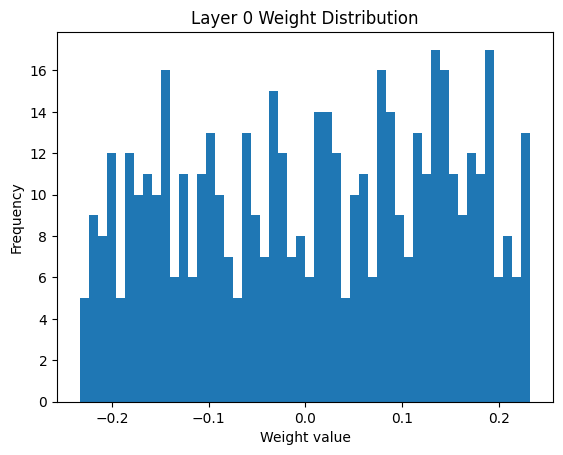

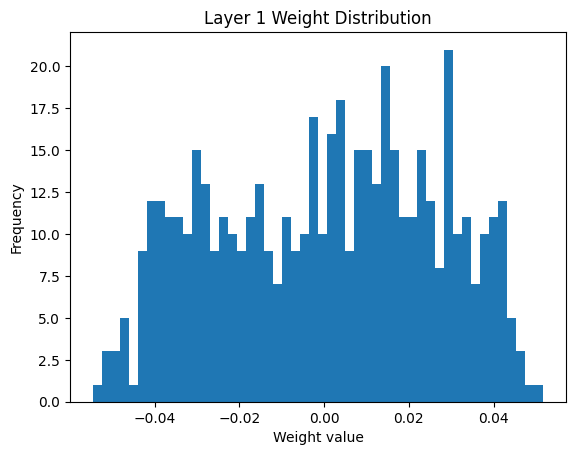

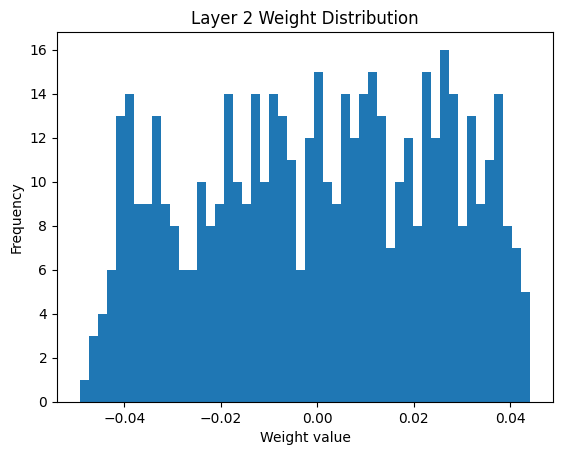

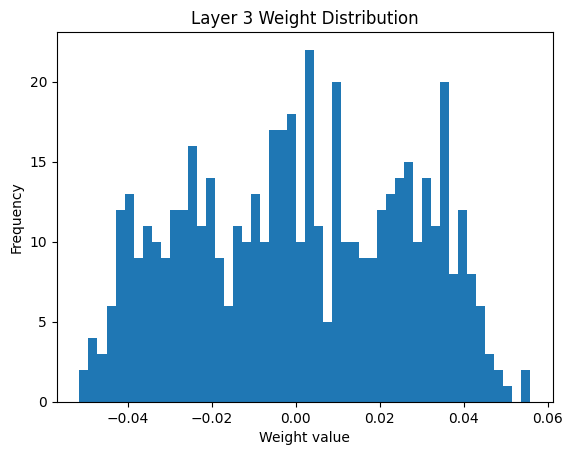

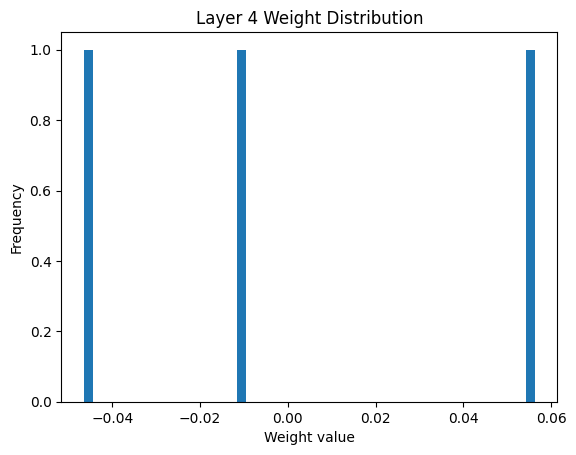

In [ ]:
# separate weights based on what is the input (interpretable)
# what about the nodes that have high frequency? 
# take top 10% of weights, and let me figure out which nodes had those weights 
# see the nodes with the highest weights corresponding to the input, and then see projection into the next layer
# 12 nodes with highest weight, node 37 had strongest possible input of input x, and then do the exactly the same thing
# --> going into direction of ellie pavlick , circuit analysis 
# follow the path of strongest weights
# 
# are the histograms between layers look similar? examine differences, bimodal, trimodal
# 
# break down into smaller info, histogram of one node, see if they look similar
# 
# go through the 19 nodes of input, see if they are similar
# if high odor node, is it also a high X node
# 
# look at pattern of weights coming into "turn left" node, see which nodes have the strongest role
# 
# HEATMAP - sort by magnitude of weights by just one row, keep columns together, both magnitude and value
# scatter plot of going into left weight vs. going into right weight, 512 nodes 

for w_i, w_val in enumerate(weights):
    plt.hist(w_val.detach().numpy()[:,1], bins=50)
    plt.title(f"Layer {w_i} Weight Distribution")
    plt.xlabel("Weight value")
    plt.ylabel("Frequency")
    plt.show()

## Hierarchical Clustering

Dendrograms show hierarchical relationships and similarities between neurons. The height of linkage between any two neurons shows their similarity. So, neurons that are closer together at the bottom are more similar. The accuracy of a dendrogram is best at the bottom.

The algorithm used below is agglomerative, meaning each data point is its own cluster at the start, and as you move up clusters become merged based on distance. The distance metric used is Euclidean (?), and the linkage method (distance between clusters) is Ward's method, which minimizes the variance within clusters.

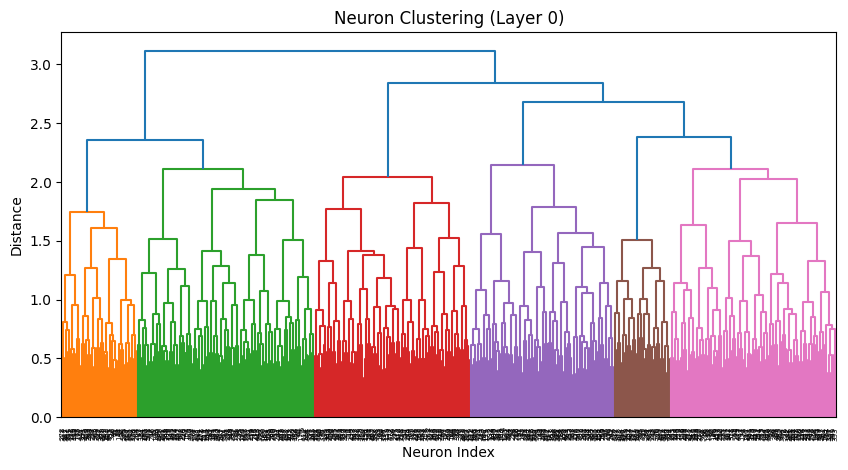

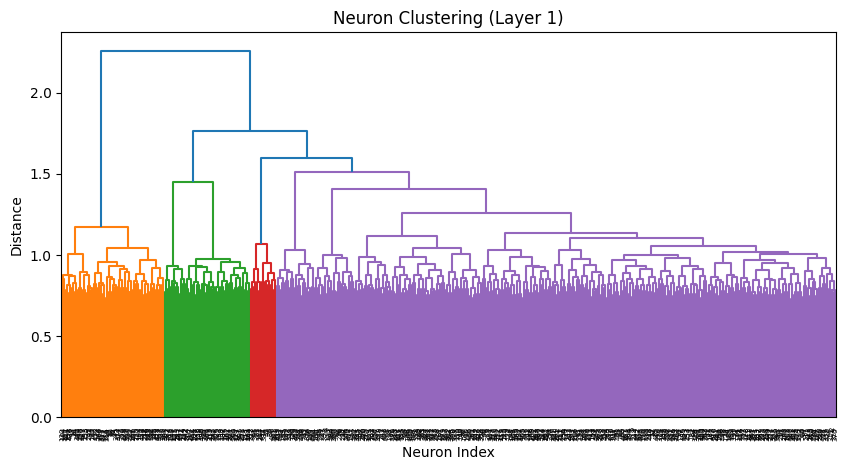

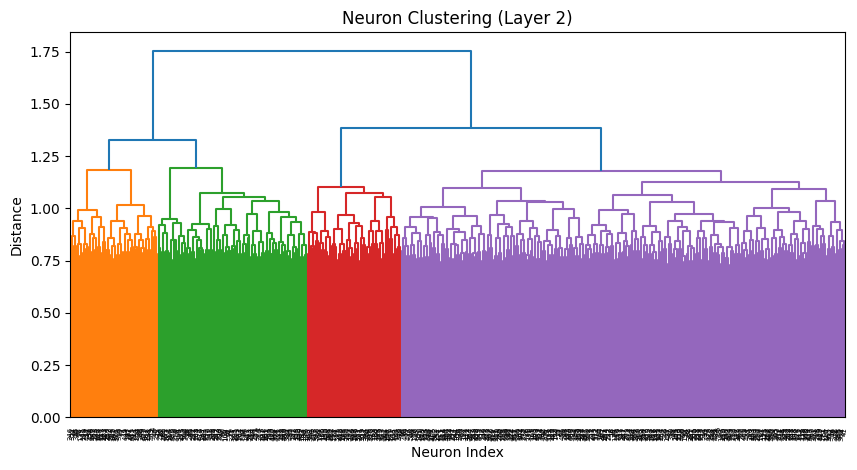

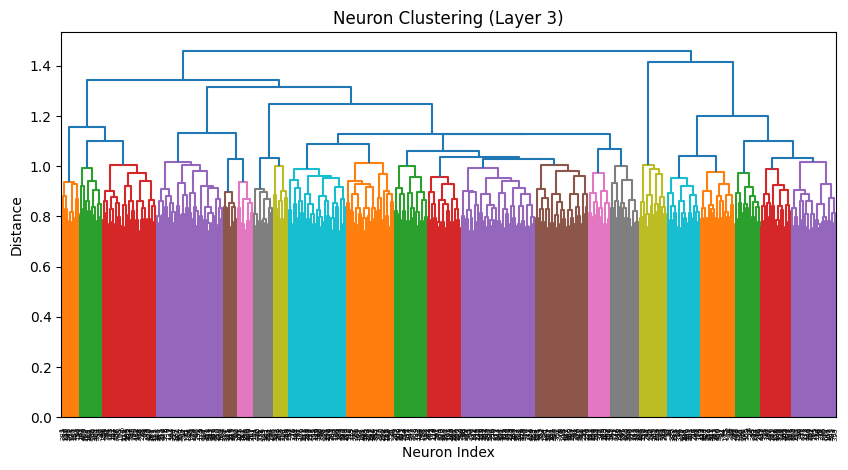

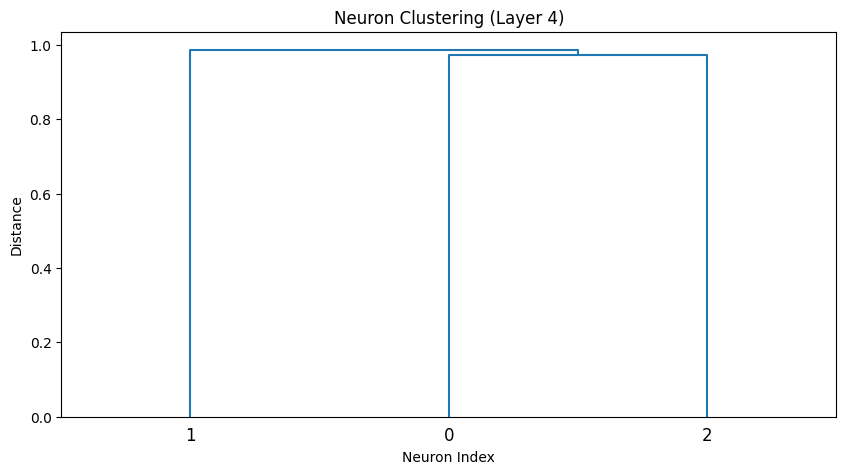

In [ ]:
# higher distance -- more different clusters
# try synthetic data for intuition
# break down by cut points -- are some of the weights dependent on the odor vs. other sensory info?
# histogram of weight from odor node on left vs. right splits -- see if the two histograms separate
# for any one of the 512 node, take its x y weight and composite into a single number (norm), make histogram for left vs. right, and see if distinction
# looking for waht is leading to cut 

# meeting with ellie about interpretability 


## compare weight vs. activation

for w_i, w_val in enumerate(weights):
    W = w_val.detach().numpy()
    Z = linkage(W, method='ward')
    # Ward's Method computes clusters by comparing cluster pairs and choosing to merge based on the least increase in within cluser variance.
    # The distance on the y-axis is the increase in variance (?)

    plt.figure(figsize=(10, 5))
    dendrogram(Z) # colors are assigned based on the color threshold. all different clusters below the threshold are assigned different colors
                  # the threshold changes each layer because the default value is dependent on Z
    plt.title(f"Neuron Clustering (Layer {w_i})")
    plt.xlabel("Neuron Index")
    plt.ylabel("Distance")
    plt.show()

## t-SNE Clustering

t-SNE is a technique to create two-dimensional "maps" from very high-dimensional data. It takes a set of points in high-dimensional space (say, our model weights), and finds a faithful representation of those points in lower-dimensional space.

In [ ]:
# Friday noon

# Sewell path analysis neural networks
# transformer attention, LLM/transformer circuit analysis 

# t-SNE Parameters
n_components = 2 # 2D projection
perplexity = [5, 20, 40] # exploring different values
max_iter = 5000
random_state = 0 # try multiple values to explore stability

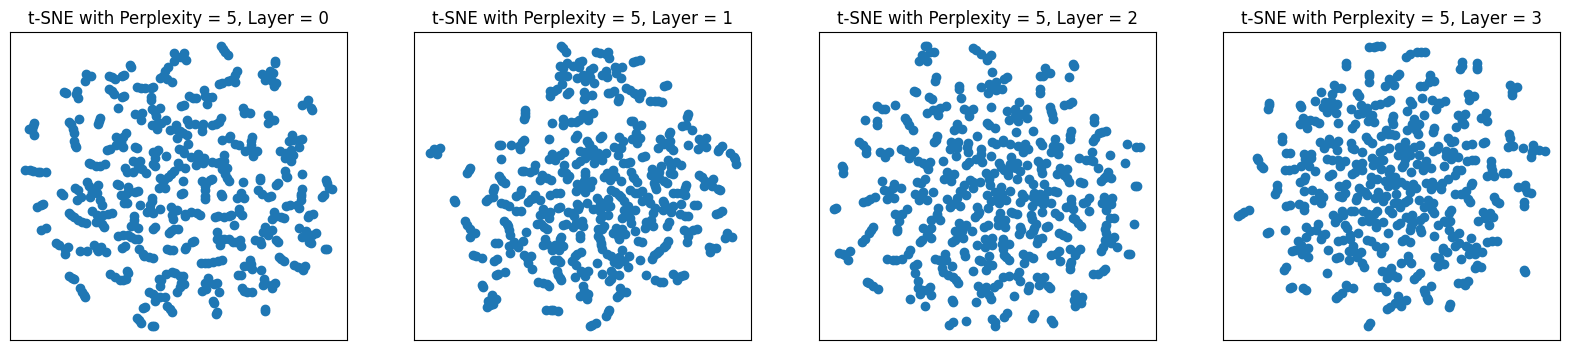

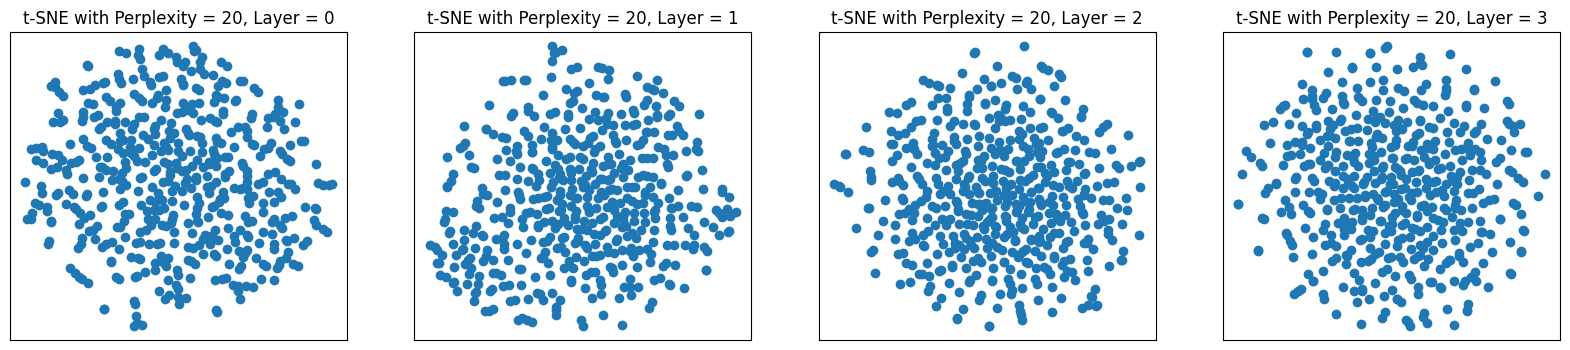

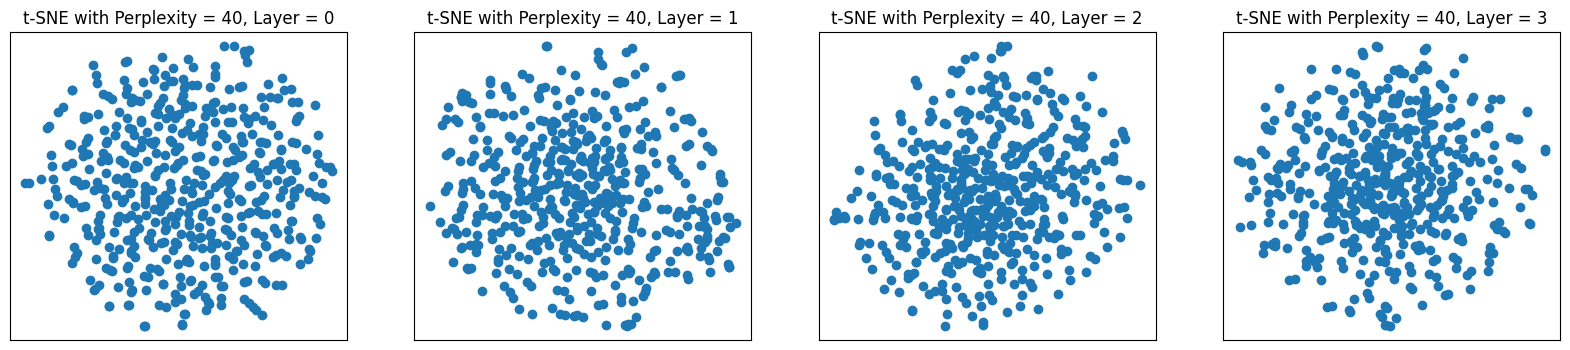

In [20]:
for p in perplexity:
    fig, ax = plt.subplots(1, len(weights) - 1, figsize=(20, 4))
    tsne = TSNE(n_components=n_components, perplexity=p, max_iter=max_iter, random_state=random_state, init='pca')
    for w_i, w_val in enumerate(weights[:-1]): # we don't take the output weights
        X = w_val.detach().numpy()
        Y = tsne.fit_transform(X)
        ax[w_i].scatter(Y[:, 0], Y[:, 1])
        ax[w_i].set_title(f"t-SNE with Perplexity = {p}, Layer = {w_i}")
        ax[w_i].xaxis.set_major_formatter(NullFormatter())
        ax[w_i].yaxis.set_major_formatter(NullFormatter())
        ax[w_i].set_xticks([])
        ax[w_i].set_yticks([])
        ax[w_i].axis("tight") 


## UMAP Clustering

/Users/juanmendez/fleischmann-research/RL_Olfaction/cartesian_polar/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/juanmendez/fleischmann-research/RL_Olfaction/cartesian_polar/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


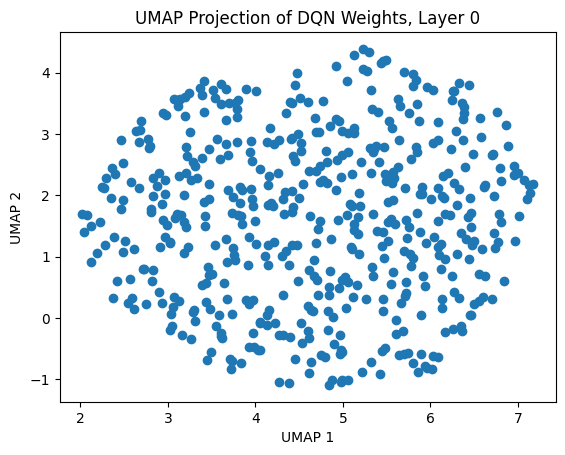

/Users/juanmendez/fleischmann-research/RL_Olfaction/cartesian_polar/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/juanmendez/fleischmann-research/RL_Olfaction/cartesian_polar/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


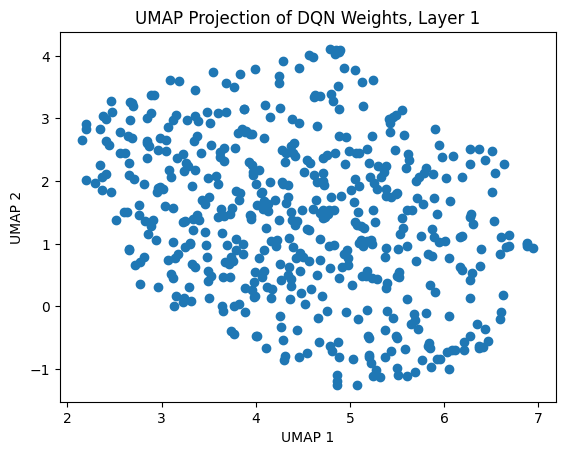

/Users/juanmendez/fleischmann-research/RL_Olfaction/cartesian_polar/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/juanmendez/fleischmann-research/RL_Olfaction/cartesian_polar/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


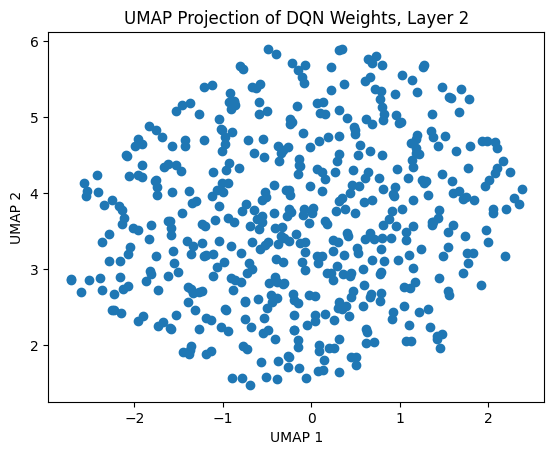

/Users/juanmendez/fleischmann-research/RL_Olfaction/cartesian_polar/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/juanmendez/fleischmann-research/RL_Olfaction/cartesian_polar/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


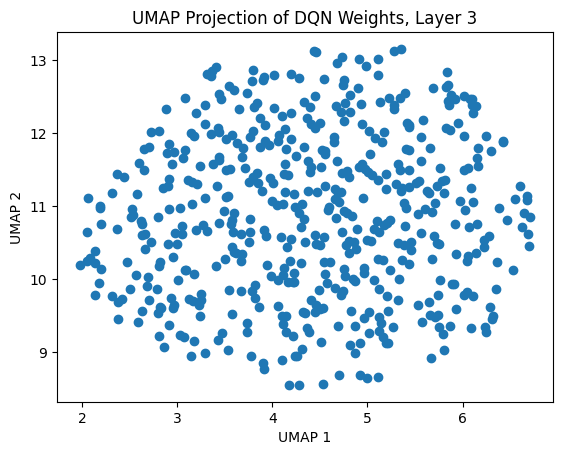

In [20]:
for w_i, w_val in enumerate(weights[:-1]):
    scaled_weights = StandardScaler().fit_transform(w_val.detach().numpy()) # normalizing the data

    # applying UMAP
    reducer = umap.UMAP(n_components=2, random_state=42)
    embedding = reducer.fit_transform(scaled_weights)

    plt.scatter(embedding[:, 0], embedding[:, 1])
    plt.title(f"UMAP Projection of DQN Weights, Layer {w_i}")
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.show()

    # kmeans = KMeans(n_clusters=3)
    # labels = kmeans.fit_predict(embedding)

    # plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap='tab10')
    # plt.title("Clusters in DQN Weights via UMAP + KMeans")
    # plt.show

## Activation Analysis

In [ ]:
net = data_dict['net']
env = data_dict['env']

In [ ]:
input_cond, activations_layer_df = utils.get_activations_learned(
        net=net,
        env=env,
        layer_inspected=p.layer_inspected,
        contexts_labels=CONTEXTS_LABELS,
    )